In [ ]:
!pip install haystack-ai
!pip install "sentence-transformers>=3.0.0" "huggingface_hub>=0.23.0"
!pip install pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.0/380.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 4.5 MB/s eta 0:00:00


In [ ]:
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.converters import PyPDFToDocument
from haystack.components.preprocessors import DocumentCleaner
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.writers import DocumentWriter
from haystack.components.embedders import  OpenAITextEmbedder, OpenAIDocumentEmbedder
from google.colab import userdata
import os
os.environ["OPENAI_API_KEY"]=userdata.get('OPENAI_API_KEY')

document_store = InMemoryDocumentStore()
document_embedder=OpenAIDocumentEmbedder()

pipeline = Pipeline()
pipeline.add_component("converter", PyPDFToDocument())
pipeline.add_component("cleaner", DocumentCleaner())
pipeline.add_component("splitter", DocumentSplitter(split_by="sentence", split_length=5))
pipeline.add_component("embedder", instance=document_embedder)
pipeline.add_component("writer", DocumentWriter(document_store=document_store))
pipeline.connect("converter", "cleaner")
pipeline.connect("cleaner", "splitter")
pipeline.connect("splitter", "embedder")
pipeline.connect("embedder", "writer")

file_names=["/content/10.54569-aair.1401234-3583294.pdf","/content/SÜPER UYGULAMALAR İÇİN GENİŞLETİLEBİLİR MİMARİLİ SOHBET BOTU_ İSTERLER, TASARIM, PROTOTİP Sunum.pdf","/content/SÜPER UYGULAMALAR İÇİN GENİŞLETİLEBİLİR MİMARİLİ SOHBET BOTU_ İSTERLER, TASARIM, PROTOTİP.pdf","/content/TR-ZAMANSAL-DATASET_ TÜRKÇE ZAMANSAL İFADELER VERİ SETİ.pdf","/content/Time_Extractor.pdf"]

pipeline.run({"converter": {"sources": file_names}})

Calculating embeddings: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


{'embedder': {'meta': {'model': 'text-embedding-ada-002',
   'usage': {'prompt_tokens': 27311, 'total_tokens': 27311}}},
 'writer': {'documents_written': 223}}

In [ ]:
from haystack.components.retrievers import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator


text_embedder = OpenAITextEmbedder()
retriever = InMemoryEmbeddingRetriever(document_store)

template = """Given these documents, answer the question.
              Documents:
              {% for doc in documents %}
                  {{ doc.content }}
              {% endfor %}
              Question: {{query}}
              Answer:"""

prompt_builder=PromptBuilder(template=template)

llm = OpenAIGenerator()

In [ ]:
rag_pipeline = Pipeline()
rag_pipeline.add_component("text_embedder", text_embedder)
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", llm)

rag_pipeline.connect("text_embedder.embedding","retriever.query_embedding")
rag_pipeline.connect("retriever","prompt_builder")
rag_pipeline.connect("prompt_builder","llm")

🚅 Components
  - text_embedder: OpenAITextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

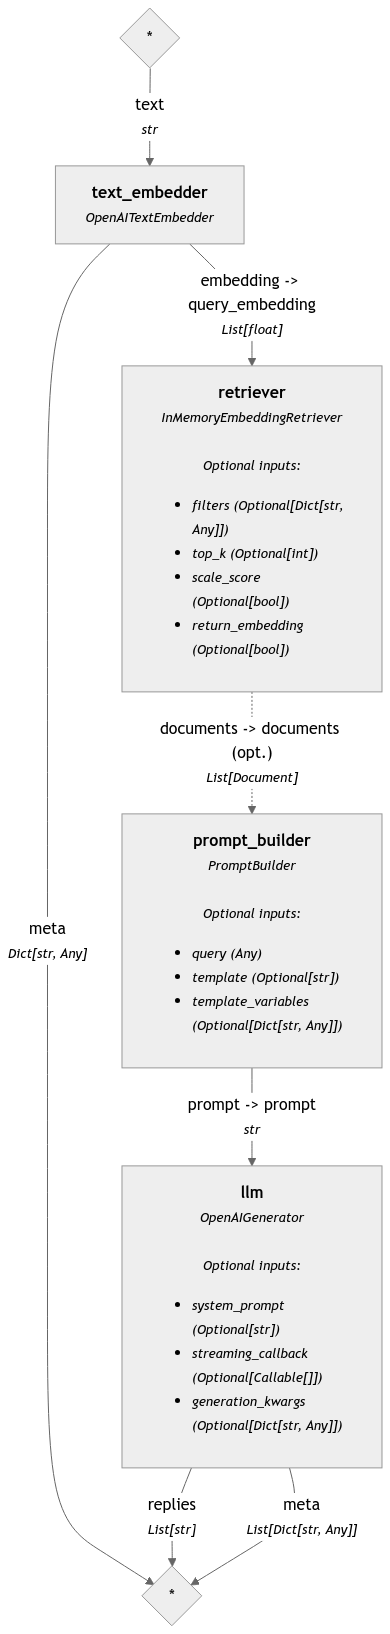

In [ ]:
rag_pipeline.show()

In [ ]:
query = """What are the differneces betwwen in English and Turkish languages when we try to extract temporal information from sentences. What is the problem with Religious Holidays in Turkey """
result = rag_pipeline.run(data={"prompt_builder": {"query":query}, "text_embedder": {"text": query}})
print(result["llm"]["replies"][0])

When extracting temporal information from sentences in English and Turkish, several differences and challenges arise due to the structural characteristics of the languages and the specific cultural context of Turkey's religious holidays.

### Differences in Temporal Expression Extraction:

1. **Language Structure**:
   - **Agglutinative Nature**: Turkish is an agglutinative language, meaning that words are formed by stringing together morphemes. This can complicate the extraction of temporal expressions, as the relevant information might be embedded within complex word forms rather than being distinct, as is often the case in English.
   - **Time Markers**: English utilizes distinct expressions such as AM and PM to denote timeframes throughout the day. In contrast, Turkish does not have direct equivalents. Instead, temporal expressions in Turkish often rely on relative terms such as "öğle" (noon), "akşam" (evening), and "gece" (night).

2. **Temporal Concepts**:
   - **Lack of Direct E